# Projet Final : Apprentissage statistique

## Comparaison de différentes méthodes de classification

Ce dernier projet du module **HMMA308 : Apprentissage statistique**, a pour objectif d'analyser et comparer différentes méthodes de classification, sur la base de données *digits*, en comparant leurs erreurs de classification ainsi que leur score $F1$. 
Nous allons suivre un protocole expérimental qui consiste à couper ces données en deux parties (75% pour l'apprentissage et 25% pour la validation). Ensuite, nous allons entraîner les méthodes suivantes sur la partie d'apprentissage :  

$\bullet$ Naive Bayes  
$\bullet$ LDA  
$\bullet$ Régression Logistique  
$\bullet$ QDA  
$\bullet$ k-NN (en prenant le nombre de voisins $k=1$)  
$\bullet$ k-NN (en choisissant $k$ par validation croisée *V-fold* avec $V = 6$)  
$\bullet$ Méthode de notre choix ???

#### Packages nécessaires :

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import load_digits, load_wine
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

import keras

from time import perf_counter
import random
from pandas import DataFrame, concat, read_csv

from keras.datasets import fashion_mnist

Using TensorFlow backend.


### Préparation et synthèse de la base de données :

In [2]:
# Chargement de la base de données digits :
digits = load_digits()
X, y = digits.data, digits.target


La base de données contient 1797 images 8x8 (digits)
Le nombre de features est : 64
Le nombre de classes associées (target) est : 10


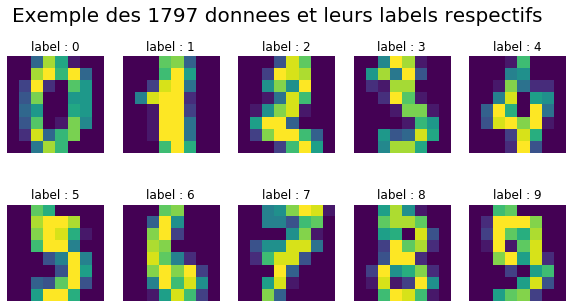

In [3]:
# Contenu et dimensionnalité du dataset Digits :

n_sample = X.shape[0]

n_features = X.shape[1]

target_names = digits.target_names
n_classes = target_names.shape[0]

print("La base de données contient", n_sample, "images 8x8 (digits)")
print("Le nombre de features est :", n_features)
print("Le nombre de classes associées (target) est :", n_classes)

# Visualisation du dataset :

plt.figure(figsize=(10, 5))
for index, (image, label) in enumerate(
        list(zip(digits.images, digits.target))[0:n_classes]):
    plt.suptitle("Exemple des " + str(n_sample) +
                 " donnees et leurs labels respectifs",
                 fontsize=20)
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, interpolation='None')
    plt.title('label : %i' % label)

Le jeu de données *digits* contient des images *(digits.data)* correspondant à des chiffres, entre $0$ et $9$, écrit à la main. Le but est donc de classifier proprement ces chiffres dans leurs labels *(digits.target)* correspondant, par la voie des différentes méthodes de classifications que l'on a cité plus en haut.

Proportions de chaque classe de 0 à  9 [0.09905398 0.10127991 0.0984975  0.10183639 0.10072343 0.10127991
 0.10072343 0.09961046 0.09682805 0.10016694]
Chaque classe contient ~  [178. 182. 177. 183. 181. 182. 181. 179. 174. 180.] digits


Text(0.5, 1.0, 'Proportion de chaque classe')

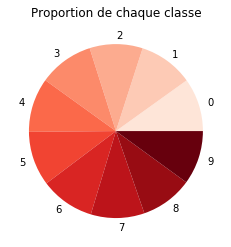

In [4]:
# Constituera par la suite les proportions des labels
labels_prop = np.zeros(n_classes)

for k in range(n_classes):
    labels_prop[k] = (y == k).sum() / n_sample

print("Proportions de chaque classe de 0 à ", n_classes - 1, labels_prop)
print("Chaque classe contient ~ ", (n_sample * (labels_prop)), "digits")

# Visualisation des proportions des classes :

colors = np.r_[np.linspace(1 / n_classes, 1, n_classes),
               np.linspace(1 / n_classes, 1, n_classes)]
mymap = plt.get_cmap("Reds")
my_colors = mymap(colors)

plt.pie(labels_prop, labels=target_names, colors=my_colors)
plt.title("Proportion de chaque classe")

### Protocol expérimental :

Nous découpons notre jeu de données en deux parties : $78\%$ pour le *Training Set* et $22\%$ pour le *Test Set* :

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.22,
                                                    random_state=42)

print("Taille du Training Set :", len(X_train))
print("Taille du Test Set :", len(X_test))

Taille du Training Set : 1401
Taille du Test Set : 396


### Choix du paramètre $k$, par validation croisée *(V-fold)*, pour l'algorithme $k$-NN :

In [6]:
def cross_validation_k(N, X_train, y_train):
    """
    Choix du paramètre k pour l'algorithme k-NN, par CV (V-fold)

    Parameters :
    ------------
    N : int, nombre de paramètres k à tester
    X_train, y_train : array, Training set to fit the model on

    """

    k_range = list(range(1, N))
    print("n_voisins à tester :", k_range)

    grid_param = dict(n_neighbors=k_range)
    print(grid_param)

    scores = ['accuracy', 'f1_macro']  # Métriques d'évaluation utilisées.

    # Classificateur appliquant le vote des k-voisins les plus proches
    knn = KNeighborsClassifier()

    # Recherche exhaustive sur des valeurs de paramètres spécifiées pour le k-nn model (V-fold, avec V = 6) :

    grid_acc = GridSearchCV(knn, grid_param, cv=6, scoring='accuracy')
    grid_f1 = GridSearchCV(knn, grid_param, cv=6, scoring='f1_macro')

    return (grid_acc, grid_f1)

In [7]:
grid_acc, grid_f1 = cross_validation_k(11, X_train, y_train)
grid_acc.fit(X_train, y_train)
grid_f1.fit(X_train, y_train)
print ("Le Meilleur paramètre trouvé est :" , grid_acc.best_params_ , 
               "avec une métrique d'évaluation accuracy de :" , grid_acc.best_score_)
print ("Le Meilleur paramètre trouvé est :" , grid_f1.best_params_ , 
               "avec une métrique d'évaluation f1_macro de :" , grid_f1.best_score_)

n_voisins à tester : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
Le Meilleur paramètre trouvé est : {'n_neighbors': 1} avec une métrique d'évaluation accuracy de : 0.9850107066381156
Le Meilleur paramètre trouvé est : {'n_neighbors': 1} avec une métrique d'évaluation f1_macro de : 0.9849351307671057


In [8]:
print("Prediction des labels pour le Test Set")

y_pred = grid_acc.predict(X_test)

print(classification_report(y_test, y_pred))

Prediction des labels pour le Test Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       0.94      1.00      0.97        31
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        39
           4       0.98      0.98      0.98        50
           5       0.98      0.98      0.98        50
           6       0.97      1.00      0.99        39
           7       1.00      0.97      0.99        35
           8       1.00      0.94      0.97        36
           9       0.95      0.93      0.94        42

    accuracy                           0.98       396
   macro avg       0.98      0.98      0.98       396
weighted avg       0.98      0.98      0.98       396



$\bullet$ **Moralité :** Le choix optimal du paramètre $k$, pour la classification *k-NN*, par la voie de la validation croisée *V-fold*, est $k = 1$. En effet, ce choix maximise les métriques d'évaluation *(score)* de la validation croisée.

### Entraînement des méthodes sur le *Training Set*

Maintenant que nous avons choisi le paramètre $k = 1$ optimal pour la classification par $k$ voisins les plus proches, nous procédons donc à l'entraînement des $5$ méthodes de classification sur nos données d'apprentissage *X_train*.

#### Ajustement des modèles de classification :

In [9]:
def models_fitting(n_classes=n_classes,
                   k=grid_acc.best_params_,
                   X=X_train,
                   y=y_train):
    """
    Parameters :
    ------------
        n_classes : (int) Number of classes in our data set.
        k : (int) Number of k neighbors. Default : Optimal k by CV V_fold.
        X, y = Data. Default train and test sets defined earlier.

    Output :
    --------
        train_time : list of training times for each method.
        models : list of models (will be used further).

    """
    # Pour les méthodes GNB, LDA et QDA, l'argument priors = Probabilités à priori des classes.
    # Ici, nous les initions à 0.1 pour chaque classe.

    # Classification naïve bayesienne :

    GNB = GaussianNB(priors=np.ones(n_classes) / n_classes)

    # Analyse discriminante linéaire (LDA) :

    # On initialise les probabilités des différentes classes (P(Y=k)) par une loi uniforme sur 0,1,2,...,9.
    LDA = LinearDiscriminantAnalysis(priors=np.ones(n_classes) / n_classes)

    # Régression Logistique :

    LR_liblin = LogisticRegression(random_state=0,
                                   solver='liblinear',
                                   fit_intercept=False,
                                   multi_class='auto')
    LR_newton = LogisticRegression(solver='newton-cg',
                                   tol=1,
                                   multi_class='auto')

    # Analyse discriminante quadratique (QDA) :

    QDA = QuadraticDiscriminantAnalysis(priors=np.ones(n_classes) / n_classes)

    # Classification par k voisins les plus proches (k_NN) :

    KNN = KNeighborsClassifier(n_neighbors=k)

    # Machine à vecteurs de support (SVM) :

    SVM = SVC(kernel='poly')
    # On choisit le noyau 'poly' car il donne de meilleurs résultats que le noyau 'rbf' paramètre par défaut.

    # Random Forests :

    RF = RandomForestClassifier(n_estimators=300,
                                class_weight='balanced',
                                n_jobs=2,
                                random_state=42)

    # Entraînement des différentes méthodes sur le Training Set et calcul du temps de calcul pour chacun :

    models = [GNB, KNN, LDA, LR_liblin, LR_newton, QDA, SVM, RF]

    train_time = []

    for i, model in enumerate(models):

        t1 = perf_counter()
        model.fit(X_train, y_train)
        t2 = perf_counter()

        train_time = np.append(train_time, t2 - t1)

    return (train_time, models)

In [10]:
names = [
    "GNB", "1-NN", "KNN"
    "LDA", "LR_liblinear", "LR_newton", "QDA", "SVM", "RF"
]

train_time = models_fitting(n_classes, k=1)[0]

train_times = DataFrame(
    [train_time],
    index=["Temps de calcul pour l'apprentissage, en seconde"],
    columns=names)
train_times

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,GNB,1-NN,KNNLDA,LR_liblinear,LR_newton,QDA,SVM,RF
"Temps de calcul pour l'apprentissage, en seconde",0.004988,0.005241,0.026848,0.229563,0.107568,0.016926,0.054501,0.753482


### Validation de la performance de chaque modèle :

#### Proportion d'erreurs de classification faite sur le Test Set : 

In [11]:
def classification_errors(models, X=X_test, y=y_test):
    """
    Adjust the classification errors for each model from 'models'.

    Parameters :
    ------------
        models : list of sklearn objects models.
        X, y : Arrays to be tested on. Default : X_test, y_test.

    Output :
    --------
        erreurs : (list) classification errors for each model
    """

    erreurs = []

    for i, model in enumerate(models):
        erreurs = np.append(erreurs, (1 - model.score(X_test, y_test)) * 100)

    return (erreurs)

In [12]:
models = models_fitting(n_classes, k = 1)[1]

erreurs = classification_errors(models)
errors_frame = DataFrame([erreurs], index = ["Proportion d'erreurs de classification"], columns = names)
errors_frame

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,GNB,1-NN,KNNLDA,LR_liblinear,LR_newton,QDA,SVM,RF
Proportion d'erreurs de classification,13.636364,2.020202,5.30303,3.535354,2.525253,10.858586,1.262626,2.272727


#### Le score F1 sur le Test Set, pour chaque méthode :

In [13]:
def f1_score_test(models, x=X_test, y=y_test):
    """
    Adjust the F1 scores for each model from 'models'.

    Parameters :
    ------------
        models : list of sklearn objects models.
        X, y : Arrays to be tested on. Default : X_test, y_test.

    Output :
    --------
        score_F1 : (list) F1 scores for each model.
        test_time : (list) Time for validation in seconds.
    """

    score_F1 = []
    test_time = []

    for i, model in enumerate(models):

        t0 = perf_counter()
        y_pred = model.predict(X_test)
        t1 = perf_counter()

        test_time = np.append(test_time, t1 - t0)

        score_F1 = np.append(score_F1, f1_score(y_test,
                                                y_pred,
                                                average='macro'))

    return (score_F1, test_time)

In [14]:
test_time = f1_score_test(models)[1]

validation_times = DataFrame(
    [test_time],
    index=["Temps de calcul pour la validation, en seconde"],
    columns=names)
validation_times

,GNB,1-NN,KNNLDA,LR_liblinear,LR_newton,QDA,SVM,RF
"Temps de calcul pour la validation, en seconde",0.010481,0.102767,0.000449,0.000352,0.000317,0.002335,0.014873,0.104215


In [15]:
score_F1 = f1_score_test(models)[0]

scoref1_frame = DataFrame([score_F1],
                          index=["Score F1 pour chaque méthode"],
                          columns=names)
scoref1_frame

,GNB,1-NN,KNNLDA,LR_liblinear,LR_newton,QDA,SVM,RF
Score F1 pour chaque méthode,0.860286,0.980013,0.944863,0.965019,0.976286,0.892469,0.987588,0.978283


### Synthèse de la performance des méthodes de classification :

In [16]:
synthese = concat(
    [train_times, validation_times, errors_frame, scoref1_frame], )
synthese

,GNB,1-NN,KNNLDA,LR_liblinear,LR_newton,QDA,SVM,RF
"Temps de calcul pour l'apprentissage, en seconde",0.004988,0.005241,0.026848,0.229563,0.107568,0.016926,0.054501,0.753482
"Temps de calcul pour la validation, en seconde",0.010481,0.102767,0.000449,0.000352,0.000317,0.002335,0.014873,0.104215
Proportion d'erreurs de classification,13.636364,2.020202,5.303030,3.535354,2.525253,10.858586,1.262626,2.272727
Score F1 pour chaque méthode,0.860286,0.980013,0.944863,0.965019,0.976286,0.892469,0.987588,0.978283


#### Matrices de confusion :

Nous allons afficher les matrices de confusions de la meilleure et de la pire des méthodes obtenues (au sens de la proportion d'erreurs de classification)

In [17]:
print("Le méthode ",
      DataFrame.idxmin(errors_frame, axis=1)[0],
      ", a la plus petite proportion d'erreurs de classification :",
      DataFrame.min(errors_frame, axis=1)[0])

print("Le méthode ",
      DataFrame.idxmax(errors_frame, axis=1)[0],
      ", a la plus grande proportion d'erreurs de classification :",
      DataFrame.max(errors_frame, axis=1)[0])

Le méthode  SVM , a la plus petite proportion d'erreurs de classification : 1.2626262626262652
Le méthode  GNB , a la plus grande proportion d'erreurs de classification : 13.636363636363635


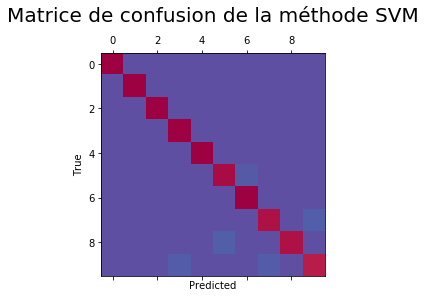

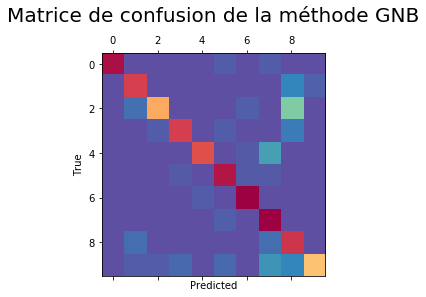

In [18]:
# Indices de la "meilleure" et "pire" des méthodes.
idx_models = [np.argmin(erreurs), np.argmax(erreurs)]

for i in range(2):
    y_pred = models[idx_models[i]].predict(X_test)
    MC = metrics.confusion_matrix(y_test, y_pred)
    MC_norm = 1.0 * MC / MC.sum(axis=1)[:, np.newaxis]
    # On normalise la matrice de confusion pour qu'elle représente
    # la proportion et pas le nombre d'erreurs pour chaque classe.
    plt.matshow(MC_norm, cmap=plt.cm.Spectral_r, interpolation='none')
    plt.title("Matrice de confusion de la méthode " + names[idx_models[i]],
              fontsize=20,
              pad=20)
    plt.xlabel("Predicted")
    plt.ylabel("True")

$\bullet$  **Moralité :** Pour le classifieurs SVM, la diagonale est en rouge et pour le reste c'est en bleu. On observe donc très peu d'erreurs. Contrairement au GNB, les erreurs sont très courantes


### Courbe d'apprentissage sur la méthode *k-NN* :

In [19]:
def plot_learning_curve(estimator,
                        title,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\utilisateur\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 720x720 with 0 Axes>

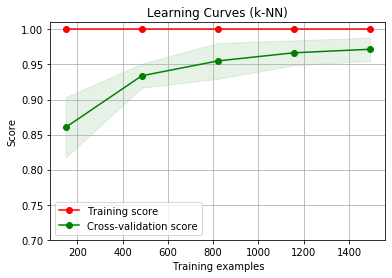

In [20]:
title = "Learning Curves (k-NN)"
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plt.figure(figsize=(10, 10))

plot_learning_curve(models[1], title, X, y, ylim=(0.7, 1.01), cv=6, n_jobs=4)

### Synthèse :

$\bullet$ Nous remarquons que pour les méthodes GNB et KNN, la phase entraînement est très rapide. Cependant, la phase de validation est très longue.  
$\bullet$ Pour la LR et LDA, elles sont très lentes pendant la phase entraînement. Or, très rapide pendant la validation.  

Moralité : Un classifieur qui prend du temps à apprendre, prend les décisions rapidement. Et inversement, si l'apprentissage est rapide, la prise de décision tarde. 
Nous pouvons dire que intuitivement cela est très logique.

## Application sur notre base de données :

Nous utilisons ici la base de données *wine* de *sklearn*. Nous avons utilisé cette base de données, comme dernier recours, après avoir essayé plusieurs base de données. En effet, nous avons eu des difficultés concernant :  

$\bullet$ **Fashion MNIST** : Quand on "reshape" les images, on obtient un X.shape = (60000, 28x28) ce qui nous plante le notebook à chaque fois.  
$\bullet$ **Datasets Kaggle** : On a trouvé pas mal de datasets qui étaient bons pour notre projet. Par contre, nous n'arrivons pas a extraire l'URL, c'est, apparemment, lié au fait qu'il faut se connecter sur Kaggle. Et vu que l'énoncé nous demande de ne pas télécharger les datasets, on pouvait pas faire autrement.  
$\bullet$ **UCI** : Nous avons trouvé ici 2 types de problèmes. La majorité des bases de données étaient soit avec des proportions différentes pour les classes, chose qui colait pas avec notre algo. Soit, des valeurs manquantes et donc si on les enlève on retombe sur le premier problème.

Finalement nous avons utilisé *make_blobs*, *iris* et *wine*. Et nous somme resté sur la dernière. Cependant, les résultats ne sont pas satisfaisants et les datasets ne sont pas très intéressants.

#### Importer la base de données :

In [21]:
wine = load_wine()
X, y = wine.data, wine.target

#### Contenu et dimensionnalité du dataset :

In [22]:
print(wine.feature_names)
print(wine.target_names)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


In [23]:
n_sample = X.shape[0]

n_features = X.shape[1]

target_names = wine.target_names
n_classes = target_names.shape[0]

print("La base de données contient", n_sample, "observations")
print("Le nombre de features est :", n_features)
print("Le nombre de classes associées (target) est :", n_classes)

La base de données contient 178 observations
Le nombre de features est : 13
Le nombre de classes associées (target) est : 3


Proportions de chaque classe de 1 à  3 [0.33146067 0.3988764  0.26966292]
Chaque classe contient :  [59. 71. 48.]


Text(0.5, 1.0, 'Proportion de chaque classe')

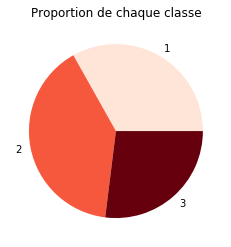

In [24]:
# Constituera par la suite les proportions des labels
labels_prop = np.zeros(n_classes)
target_names = ['1', '2', '3']

for k in range(n_classes):
    labels_prop[k] = (y == k).sum() / n_sample

print("Proportions de chaque classe de 1 à ", n_classes, labels_prop)
print("Chaque classe contient : ", (n_sample * (labels_prop)))

# Visualisation des proportions des classes :

colors = np.r_[np.linspace(0.1, 1, n_classes), np.linspace(0.1, 1, n_classes)]
mymap = plt.get_cmap("Reds")
my_colors = mymap(colors)
plt.pie(labels_prop, labels=target_names, colors=my_colors)
plt.title("Proportion de chaque classe")

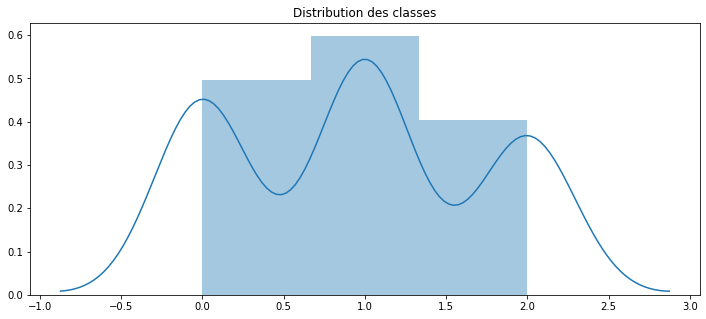

In [25]:
from seaborn import distplot
plt.figure(figsize=(12, 5))
plt.title("Distribution des classes")
ax = distplot(y)

### Protocol expérimental :

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22)

print("Taille du Training Set :", len(X_train))
print("Taille du Test Set :", len(X_test))

Taille du Training Set : 138
Taille du Test Set : 40


### Choix du paramètre $k$, par validation croisée *(V-fold)*, pour l'algorithme $k$-NN :

In [27]:
grid_acc, grid_f1 = cross_validation_k(11, X_train, y_train)
grid_acc.fit(X_train, y_train)
grid_f1.fit(X_train, y_train)
print("Le Meilleur paramètre trouvé est :", grid_acc.best_params_,
      "avec une métrique d'évaluation accuracy de :", grid_acc.best_score_)
print("Le Meilleur paramètre trouvé est :", grid_f1.best_params_,
      "avec une métrique d'évaluation f1_macro de :", grid_f1.best_score_)

n_voisins à tester : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Le Meilleur paramètre trouvé est : {'n_neighbors': 1} avec une métrique d'évaluation accuracy de : 0.717391304347826
Le Meilleur paramètre trouvé est : {'n_neighbors': 1} avec une métrique d'évaluation f1_macro de : 0.7004470569687961


In [28]:
print("Prediction des labels pour le Test Set")

y_pred = grid_acc.predict(X_test)

print(classification_report(y_test, y_pred))

Prediction des labels pour le Test Set
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.65      0.94      0.77        16
           2       0.86      0.50      0.63        12

    accuracy                           0.78        40
   macro avg       0.84      0.76      0.77        40
weighted avg       0.82      0.78      0.77        40



$\bullet$ **Moralité :** Le choix optimal du paramètre $k$, pour la classification *k-NN*, par la voie de la validation croisée *V-fold*, est $k = 3$. En effet, ce choix maximise les métriques d'évaluation *(score)* de la validation croisée.

### Entraînement des méthodes sur le *Training Set*

Maintenant que nous avons choisi le paramètre $k = 3$ optimal pour la classification par $k$ voisins les plus proches, nous procédons donc à l'entraînement des méthodes de classification sur nos données d'apprentissage *X_train*.

#### Temps de calcul pour l'apprentissage :

In [29]:
names = ["GNB", "k-NN", "LDA", "LR_liblinear", "LR_newton", "QDA", "SVM", "RF"]

train_time = models_fitting(n_classes, k=3)[0]

train_times = DataFrame(
    [train_time],
    index=["Temps de calcul pour l'apprentissage, en seconde"],
    columns=names)
train_times

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,GNB,k-NN,LDA,LR_liblinear,LR_newton,QDA,SVM,RF
"Temps de calcul pour l'apprentissage, en seconde",0.002868,0.000963,0.003737,0.004713,0.046875,0.001014,0.143308,0.38441


#### Proportion d'erreurs de classification :

In [30]:
models = models_fitting(n_classes, k=1)[1]

erreurs = classification_errors(models)
errors_frame = DataFrame([erreurs],
                         index=["Proportion d'erreurs de classification"],
                         columns=names)
errors_frame

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,GNB,k-NN,LDA,LR_liblinear,LR_newton,QDA,SVM,RF
Proportion d'erreurs de classification,2.5,22.5,2.5,5.0,5.0,2.5,2.5,2.5


#### Temps de calcul pour la validation :

In [31]:
test_time = f1_score_test(models)[1]

validation_times = DataFrame(
    [test_time],
    index=["Temps de calcul pour la validation, en seconde"],
    columns=names)
validation_times

,GNB,k-NN,LDA,LR_liblinear,LR_newton,QDA,SVM,RF
"Temps de calcul pour la validation, en seconde",0.001027,0.003987,0.000287,0.000223,0.000356,0.000398,0.000186,0.111563


#### Score F1 pour chaque méthode

In [32]:
score_F1 = f1_score_test(models)[0]

scoref1_frame = DataFrame([score_F1],
                          index=["Score F1 pour chaque méthode"],
                          columns=names)
scoref1_frame

,GNB,k-NN,LDA,LR_liblinear,LR_newton,QDA,SVM,RF
Score F1 pour chaque méthode,0.975406,0.769967,0.975914,0.951407,0.951407,0.975406,0.975406,0.975406


#### Synthèse : 

In [33]:
synthese = concat(
    [train_times, validation_times, errors_frame, scoref1_frame], )
synthese

,GNB,k-NN,LDA,LR_liblinear,LR_newton,QDA,SVM,RF
"Temps de calcul pour l'apprentissage, en seconde",0.002868,0.000963,0.003737,0.004713,0.046875,0.001014,0.143308,0.384410
"Temps de calcul pour la validation, en seconde",0.001027,0.003987,0.000287,0.000223,0.000356,0.000398,0.000186,0.111563
Proportion d'erreurs de classification,2.500000,22.500000,2.500000,5.000000,5.000000,2.500000,2.500000,2.500000
Score F1 pour chaque méthode,0.975406,0.769967,0.975914,0.951407,0.951407,0.975406,0.975406,0.975406


#### Matrices de confusion de la meilleure et pire méthode :

In [34]:
print("Le méthode ",
      DataFrame.idxmin(errors_frame, axis=1)[0],
      ", a la plus petite proportion d'erreurs de classification :",
      DataFrame.min(errors_frame, axis=1)[0])

print("Le méthode ",
      DataFrame.idxmax(errors_frame, axis=1)[0],
      ", a la plus grande proportion d'erreurs de classification :",
      DataFrame.max(errors_frame, axis=1)[0])

Le méthode  GNB , a la plus petite proportion d'erreurs de classification : 2.500000000000002
Le méthode  k-NN , a la plus grande proportion d'erreurs de classification : 22.499999999999996


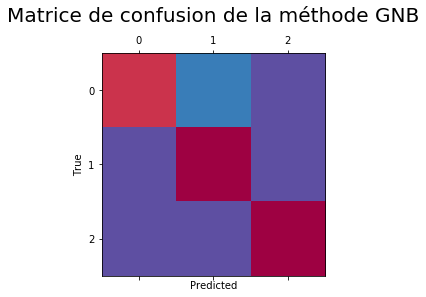

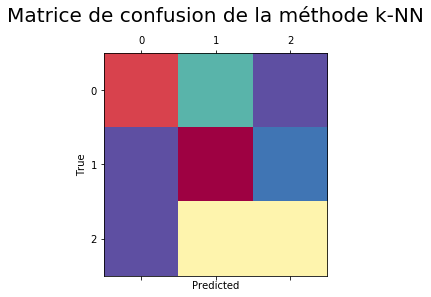

In [35]:
# Indices de la "meilleure" et "pire" des méthodes.
idx_models = [np.argmin(erreurs), np.argmax(erreurs)]

for i in range(2):
    y_pred = models[idx_models[i]].predict(X_test)
    MC = metrics.confusion_matrix(y_test, y_pred)
    MC_norm = 1.0 * MC / MC.sum(axis=1)[:, np.newaxis]
    # On normalise la matrice de confusion pour qu'elle représente
    # la proportion et pas le nombre d'erreurs pour chaque classe.
    plt.matshow(MC_norm, cmap=plt.cm.Spectral_r, interpolation='none')
    plt.title("Matrice de confusion de la méthode " + names[idx_models[i]],
              fontsize=20,
              pad=20)
    plt.xlabel("Predicted")
    plt.ylabel("True")

#### Courbe d'apprentissage pour k-NN :

<module 'matplotlib.pyplot' from 'C:\\Users\\utilisateur\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 720x720 with 0 Axes>

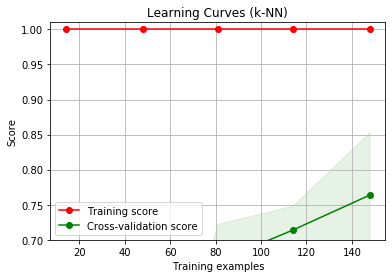

In [36]:
title = "Learning Curves (k-NN)"
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plt.figure(figsize=(10, 10))

plot_learning_curve(models[1], title, X, y, ylim=(0.7, 1.01), cv=6, n_jobs=4)